# Import Library

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode  # Ensure this is imported if used in data preparation

# Additional utilities
from torch.cuda.amp import autocast, GradScaler  # For mixed precision training
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import time  # For tracking training time

# Mount Google Drive if needed
from google.colab import drive


In [2]:
device = torch.device('cuda')
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

Using 1 GPUs
CUDA is available: True


# Data Preparation

In [3]:
drive.mount('/content/drive')

# Define paths for training, validation, and test datasets
train_path = '/content/drive/MyDrive/train'
val_path = '/content/drive/MyDrive/val'
test_path = '/content/drive/MyDrive/test'  # Ensure this path is correct

# Data transformations for training with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for stability
])

# Data transformations for validation and test sets (without augmentation)
common_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for consistency
])

# Create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)

# Define batch size (adjust based on available GPU memory)
batch_size = 16  # Adjust if necessary to avoid OutOfMemory errors

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print data sizes for verification
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


Mounted at /content/drive
Number of training samples: 2000
Number of validation samples: 16
Number of test samples: 624


# Models Set Up
Model1: MobileNetV2

Model2: ResNet-34

In [7]:
# Define MobileNetV2 as model1
model1 = models.mobilenet_v2(pretrained=True)
# Modify the first convolutional layer to accept 1-channel input for grayscale images
model1.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the classifier to output a single value for binary classification
model1.classifier[1] = nn.Sequential(
    nn.Linear(model1.classifier[1].in_features, 1),
    nn.Sigmoid()  # Use Sigmoid for binary classification
)

# Move model1 to the device (GPU/CPU)
model1 = model1.to(device)

# Print summary (optional)
print("MobileNetV2 model summary:")
print(model1)

# Define ResNet-34 as model2
model2 = models.resnet34(pretrained=True)
# Modify the first convolutional layer to accept 1-channel input for grayscale images
model2.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the fully connected layer to output a single value for binary classification
model2.fc = nn.Sequential(
    nn.Linear(model2.fc.in_features, 1),
    nn.Sigmoid()  # Use Sigmoid for binary classification
)

# Move model2 to the device (GPU/CPU)
model2 = model2.to(device)

# Print summary (optional)
print("\nResNet-34 model summary:")
print(model2)

# Load the state dictionary from the checkpoint file
checkpoint1 = torch.load('/content/drive/My Drive/checkpoints/mobilenet_v2_best.pth')
checkpoint2 = torch.load('/content/drive/My Drive/checkpoints/resnet34_best.pth')

# Load only the model state dictionary
model1.load_state_dict(checkpoint1['model_state_dict'])
model2.load_state_dict(checkpoint2['model_state_dict'])

# Set models to evaluation mode
model1.eval()
model2.eval()
print("Best models loaded and set to evaluation mode.")


MobileNetV2 model summary:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

<ipython-input-7-be72e8e609a6>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint1 = torch.load('/content/drive/My Drive/checkpoints/mobilenet_v2_best.pth')
<ipyth

Best models loaded and set to evaluation mode.


# Train Loop
Running two models

In [8]:
# Define the number of epochs
num_epochs = 20  # Adjust this value as needed for your training

# Define criterion (loss function)
criterion = nn.BCELoss()

# Define optimizers for both models
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001, weight_decay=0.002)  # Optimizer for MobileNetV2
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001, weight_decay=0.002)  # Optimizer for ResNet-34

# Define learning rate schedulers (optional)
lr_scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer1, gamma=0.9)
lr_scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer2, gamma=0.9)

# Revised training function
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, save_path, model_name, lr_scheduler=None, early_stopping_patience=4):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0  # For early stopping

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()  # Ensure labels are cast to float
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_train_loss = train_loss / len(train_loader)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        # Print epoch results
        print(f"Epoch {epoch}/{num_epochs} - {model_name} - train_loss: {avg_train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.2f}%")

        # Save best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, save_path)
            print(f"Best model checkpoint saved for {model_name} at epoch {epoch}")
        else:
            epochs_without_improvement += 1

        # Step learning rate scheduler if provided
        if lr_scheduler:
            lr_scheduler.step()

        # Early stopping
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping for {model_name} at epoch {epoch} due to no improvement in validation loss.")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Training example usage for MobileNetV2
mobilenet_train_losses, mobilenet_val_losses, mobilenet_train_accuracies, mobilenet_val_accuracies = train_model(
    model1, train_loader, val_loader, optimizer1, criterion, num_epochs, '/content/drive/MyDrive/checkpoints/mobilenet_v2_best.pth', 'MobileNetV2', lr_scheduler1
)

# Training example usage for ResNet-34
resnet34_train_losses, resnet34_val_losses, resnet34_train_accuracies, resnet34_val_accuracies = train_model(
    model2, train_loader, val_loader, optimizer2, criterion, num_epochs, '/content/drive/MyDrive/checkpoints/resnet34_best.pth', 'ResNet34', lr_scheduler2
)


Epoch 1/20 - MobileNetV2 - train_loss: 0.0492 - train_acc: 98.20% - val_loss: 0.4085 - val_acc: 81.25%
Best model checkpoint saved for MobileNetV2 at epoch 1
Epoch 2/20 - MobileNetV2 - train_loss: 0.0477 - train_acc: 98.60% - val_loss: 0.1789 - val_acc: 87.50%
Best model checkpoint saved for MobileNetV2 at epoch 2
Epoch 3/20 - MobileNetV2 - train_loss: 0.0382 - train_acc: 98.90% - val_loss: 0.5484 - val_acc: 75.00%
Epoch 4/20 - MobileNetV2 - train_loss: 0.0238 - train_acc: 99.20% - val_loss: 0.1894 - val_acc: 93.75%
Epoch 5/20 - MobileNetV2 - train_loss: 0.0328 - train_acc: 98.80% - val_loss: 0.5052 - val_acc: 81.25%
Epoch 6/20 - MobileNetV2 - train_loss: 0.0260 - train_acc: 99.05% - val_loss: 0.2442 - val_acc: 81.25%
Early stopping for MobileNetV2 at epoch 6 due to no improvement in validation loss.
Epoch 1/20 - ResNet34 - train_loss: 0.0867 - train_acc: 96.80% - val_loss: 0.4463 - val_acc: 81.25%
Best model checkpoint saved for ResNet34 at epoch 1
Epoch 2/20 - ResNet34 - train_loss: 

# Validation and Evaluation

Model: MobileNetV2
Validation Loss: 0.4375
Accuracy: 0.9215
Precision: 0.9169
Recall: 0.9615
F1 Score: 0.9387


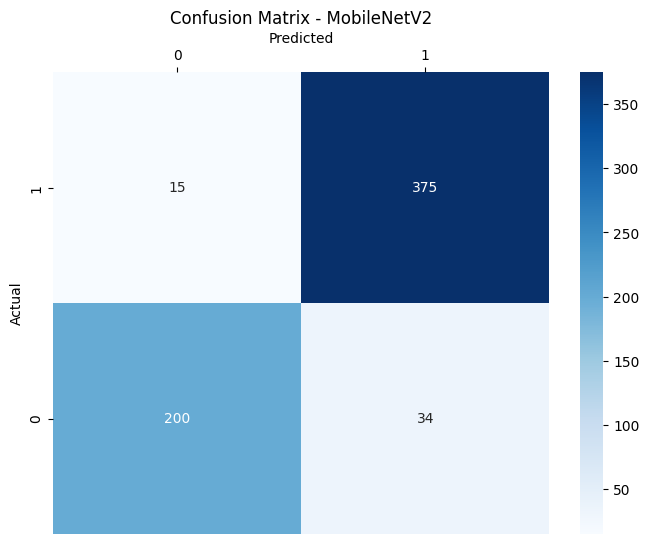

Model: ResNet-34
Validation Loss: 0.3342
Accuracy: 0.9135
Precision: 0.8871
Recall: 0.9872
F1 Score: 0.9345


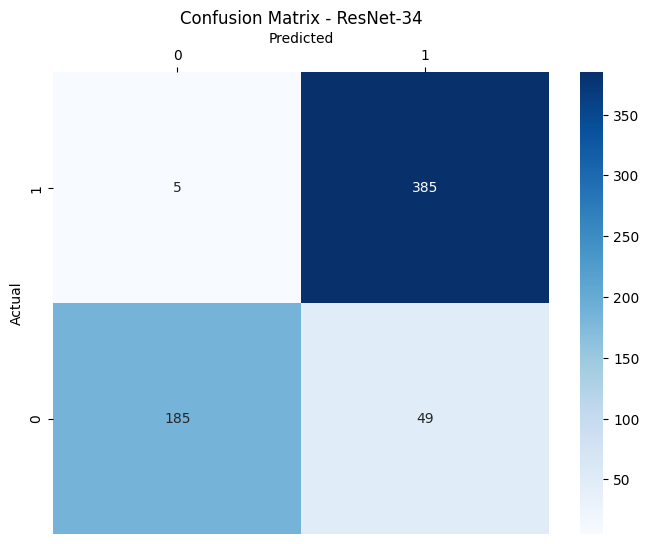

(0.33416016971489465,
 91.34615384615384,
 0.9134615384615384,
 0.8870967741935484,
 0.9871794871794872,
 0.9344660194174758)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation function for a given model and DataLoader
def evaluate_model(model, data_loader, criterion, model_name):
    model.eval()  # Set the model to evaluation mode
    val_loss, correct, total = 0.0, 0, 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1).float()  # Ensure labels are cast to float

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(data_loader)
    val_acc = 100 * correct / total

    # Calculate additional metrics
    acc = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    # Print evaluation metrics
    print(f"Model: {model_name}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix with model name
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


    # Adjust the Y-axis and X-axis
    plt.gca().invert_yaxis()  # Invert Y-axis to have '0' at the bottom
    plt.gca().xaxis.tick_top()  # Move X-axis labels to the top
    plt.gca().xaxis.set_label_position('top')  # Set X-axis label position to top

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return avg_val_loss, val_acc, acc, precision, recall, f1

# Example usage for MobileNetV2
criterion = nn.BCELoss()
evaluate_model(model1, test_loader, criterion, 'MobileNetV2')

# Example usage for ResNet-34
evaluate_model(model2, test_loader, criterion, 'ResNet-34')


# Results Visualization

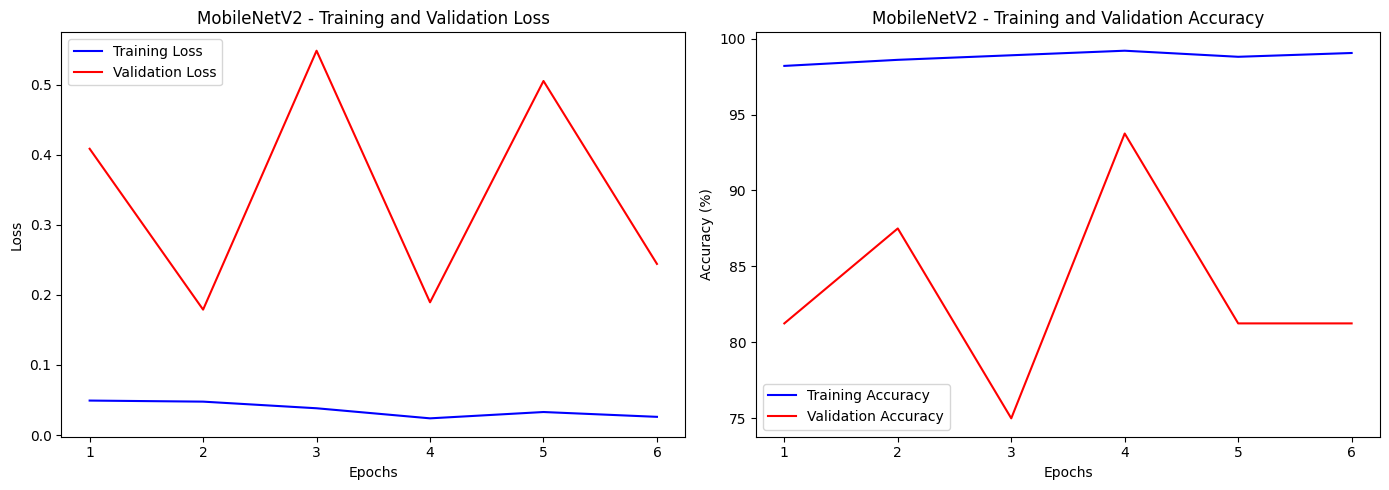

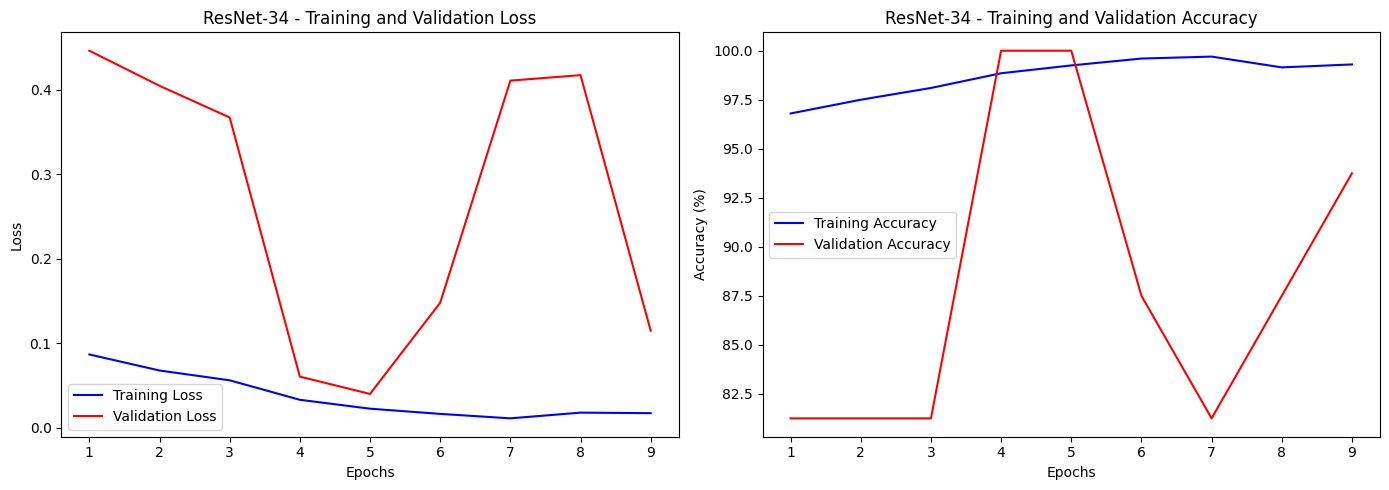

In [21]:
# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage for MobileNetV2 and ResNet-34
plot_metrics(mobilenet_train_losses, mobilenet_val_losses, mobilenet_train_accuracies, mobilenet_val_accuracies, 'MobileNetV2')
plot_metrics(resnet34_train_losses, resnet34_val_losses, resnet34_train_accuracies, resnet34_val_accuracies, 'ResNet-34')


# Side by Side Comparative Analysis of Both Models

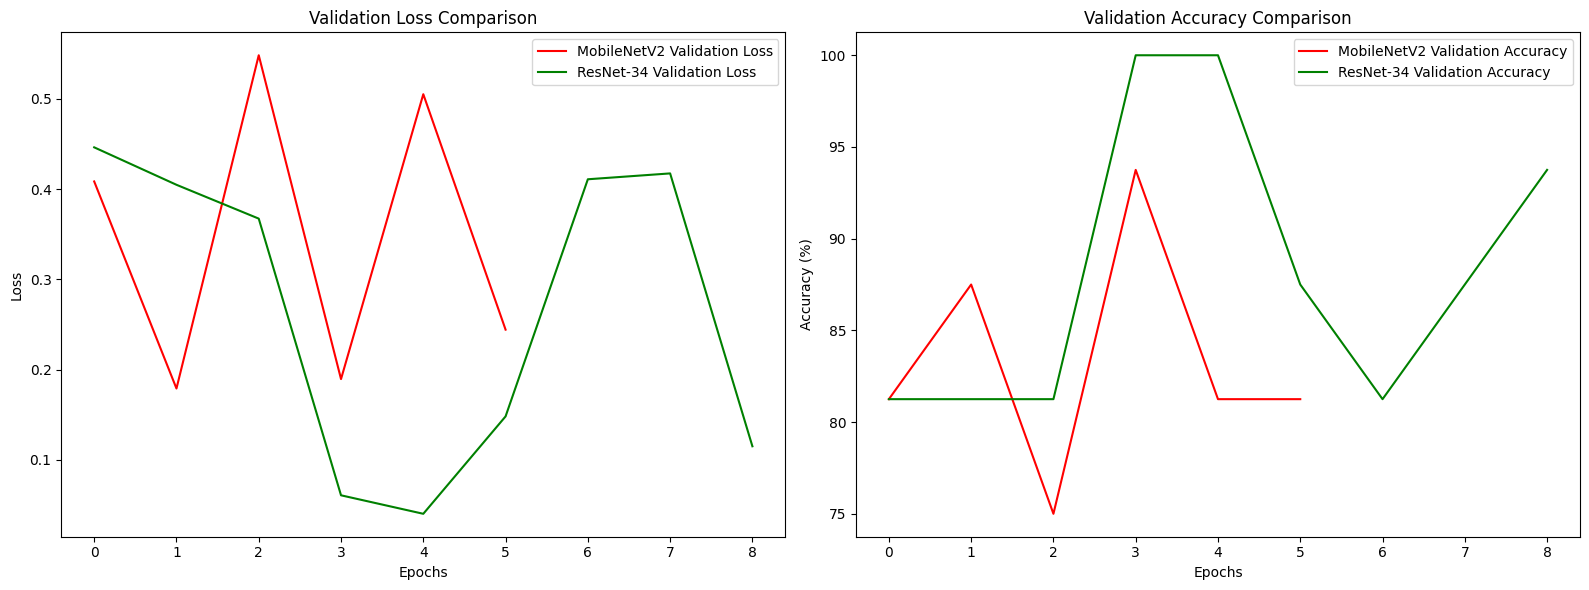

In [22]:
# Compare training/validation metrics between MobileNetV2 and ResNet-34
plt.figure(figsize=(16, 6))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(mobilenet_val_losses, 'r-', label='MobileNetV2 Validation Loss')
plt.plot(resnet34_val_losses, 'g-', label='ResNet-34 Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(mobilenet_val_accuracies, 'r-', label='MobileNetV2 Validation Accuracy')
plt.plot(resnet34_val_accuracies, 'g-', label='ResNet-34 Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


# Revised Outputs to include previously run model results
Previously early_stopping_patience was set at 2 that the trial run stopped too early. Here, previously saved best model result is included for the Result Visulaization.

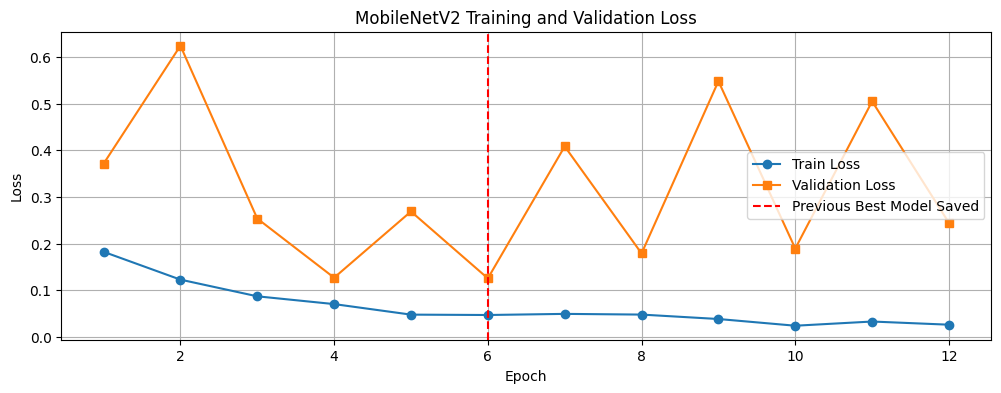

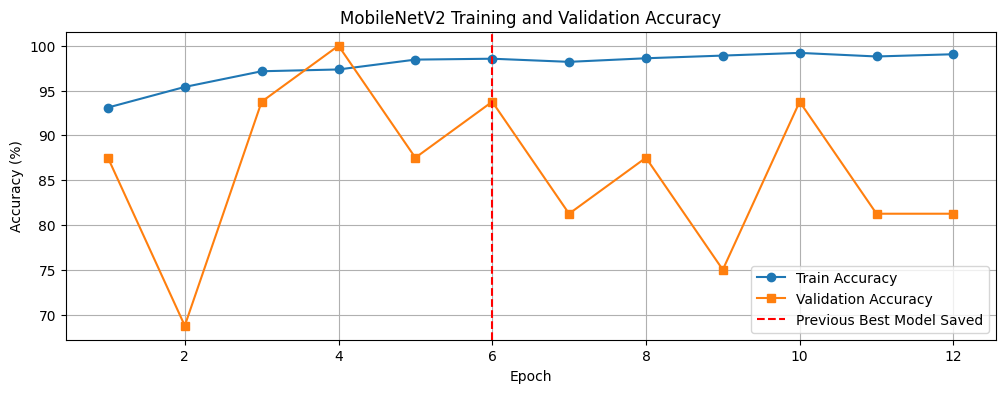

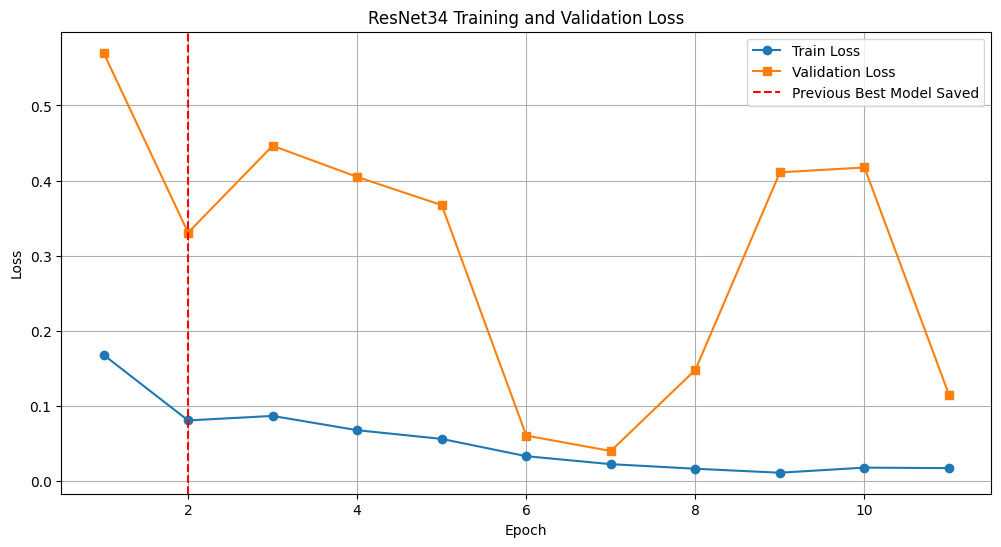

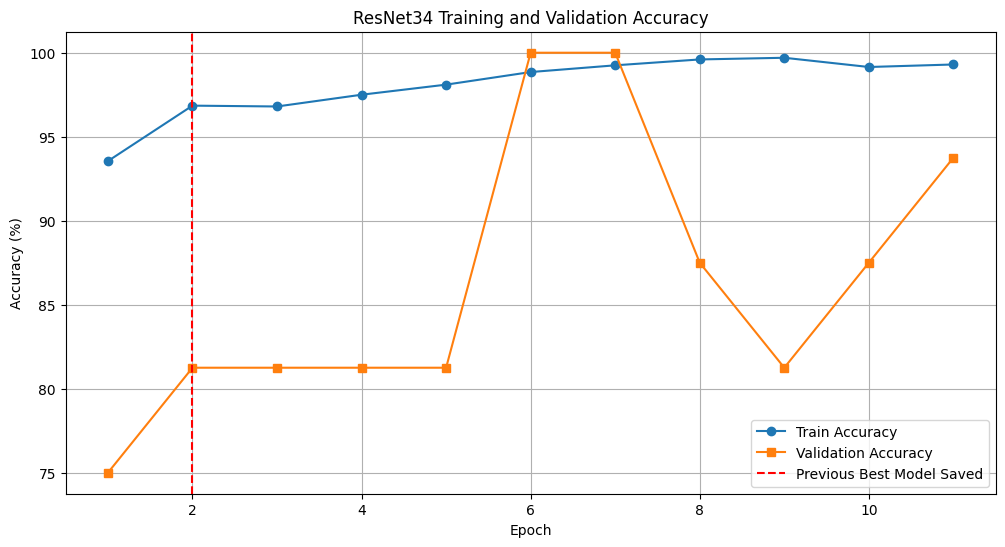

In [23]:
# Data for MobileNetV2
# Previous training session
epochs_mobilenet_previous = [1, 2, 3, 4, 5, 6]
train_loss_mobilenet_previous = [0.1824, 0.1227, 0.0869, 0.0702, 0.0476, 0.0468]
train_acc_mobilenet_previous = [93.10, 95.40, 97.15, 97.35, 98.45, 98.55]
val_loss_mobilenet_previous = [0.3713, 0.6245, 0.2537, 0.1268, 0.2689, 0.1254]
val_acc_mobilenet_previous = [87.50, 68.75, 93.75, 100.00, 87.50, 93.75]

# Current training session
epochs_mobilenet_current = [1, 2, 3, 4, 5, 6]
train_loss_mobilenet_current = [0.0492, 0.0477, 0.0382, 0.0238, 0.0328, 0.0260]
train_acc_mobilenet_current = [98.20, 98.60, 98.90, 99.20, 98.80, 99.05]
val_loss_mobilenet_current = [0.4085, 0.1789, 0.5484, 0.1894, 0.5052, 0.2442]
val_acc_mobilenet_current = [81.25, 87.50, 75.00, 93.75, 81.25, 81.25]

# Combine previous and current data
epochs_mobilenet = epochs_mobilenet_previous + [e + max(epochs_mobilenet_previous) for e in epochs_mobilenet_current]
train_loss_mobilenet = train_loss_mobilenet_previous + train_loss_mobilenet_current
train_acc_mobilenet = train_acc_mobilenet_previous + train_acc_mobilenet_current
val_loss_mobilenet = val_loss_mobilenet_previous + val_loss_mobilenet_current
val_acc_mobilenet = val_acc_mobilenet_previous + val_acc_mobilenet_current

# Plot MobileNetV2 Loss
plt.figure(figsize=(12, 4))
plt.plot(epochs_mobilenet, train_loss_mobilenet, label='Train Loss', marker='o')
plt.plot(epochs_mobilenet, val_loss_mobilenet, label='Validation Loss', marker='s')
plt.axvline(x=6, color='r', linestyle='--', label='Previous Best Model Saved')
plt.title('MobileNetV2 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot MobileNetV2 Accuracy
plt.figure(figsize=(12, 4))
plt.plot(epochs_mobilenet, train_acc_mobilenet, label='Train Accuracy', marker='o')
plt.plot(epochs_mobilenet, val_acc_mobilenet, label='Validation Accuracy', marker='s')
plt.axvline(x=6, color='r', linestyle='--', label='Previous Best Model Saved')
plt.title('MobileNetV2 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Data for ResNet34
# Previous training session
epochs_resnet_previous = [1, 2]
train_loss_resnet_previous = [0.1680, 0.0807]
train_acc_resnet_previous = [93.55, 96.85]
val_loss_resnet_previous = [0.5701, 0.3306]
val_acc_resnet_previous = [75.00, 81.25]

# Current training session
epochs_resnet_current = [1, 2, 3, 4, 5, 6, 7, 8, 9]
train_loss_resnet_current = [0.0867, 0.0677, 0.0561, 0.0331, 0.0225, 0.0164, 0.0111, 0.0179, 0.0172]
train_acc_resnet_current = [96.80, 97.50, 98.10, 98.85, 99.25, 99.60, 99.70, 99.15, 99.30]
val_loss_resnet_current = [0.4463, 0.4048, 0.3673, 0.0605, 0.0400, 0.1480, 0.4109, 0.4174, 0.1149]
val_acc_resnet_current = [81.25, 81.25, 81.25, 100.00, 100.00, 87.50, 81.25, 87.50, 93.75]

# Combine previous and current data
epochs_resnet = epochs_resnet_previous + [e + max(epochs_resnet_previous) for e in epochs_resnet_current]
train_loss_resnet = train_loss_resnet_previous + train_loss_resnet_current
train_acc_resnet = train_acc_resnet_previous + train_acc_resnet_current
val_loss_resnet = val_loss_resnet_previous + val_loss_resnet_current
val_acc_resnet = val_acc_resnet_previous + val_acc_resnet_current

# Plot ResNet34 Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_resnet, train_loss_resnet, label='Train Loss', marker='o')
plt.plot(epochs_resnet, val_loss_resnet, label='Validation Loss', marker='s')
plt.axvline(x=2, color='r', linestyle='--', label='Previous Best Model Saved')
plt.title('ResNet34 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot ResNet34 Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_resnet, train_acc_resnet, label='Train Accuracy', marker='o')
plt.plot(epochs_resnet, val_acc_resnet, label='Validation Accuracy', marker='s')
plt.axvline(x=2, color='r', linestyle='--', label='Previous Best Model Saved')
plt.title('ResNet34 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


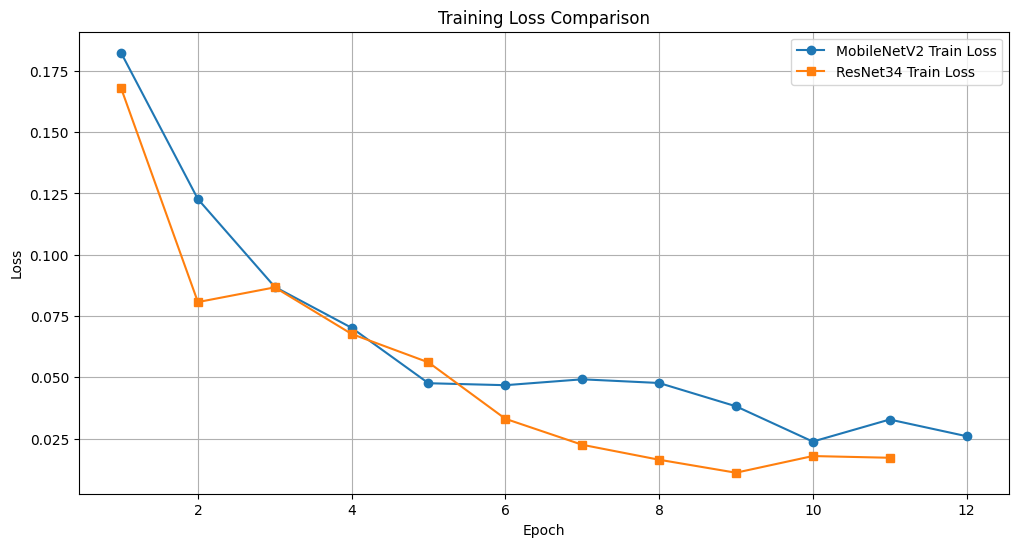

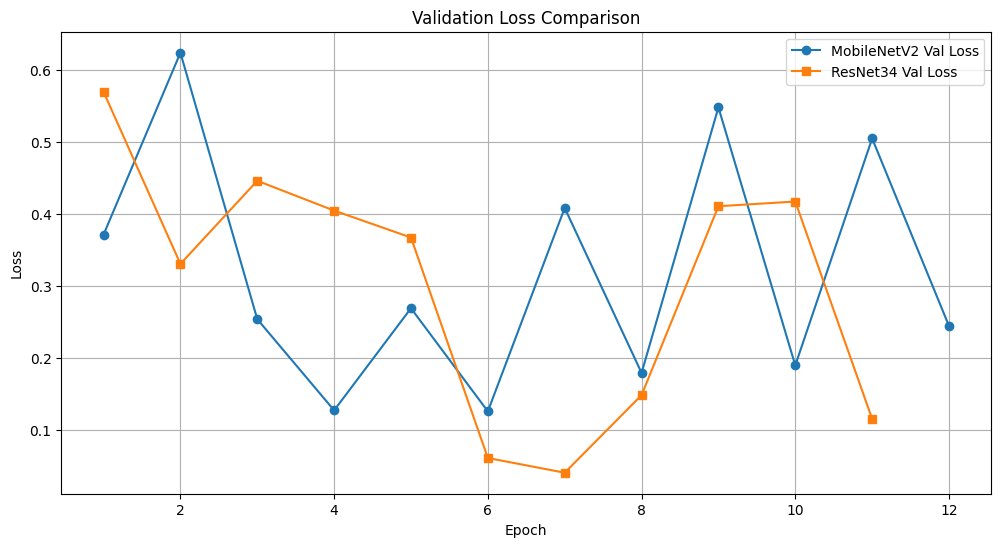

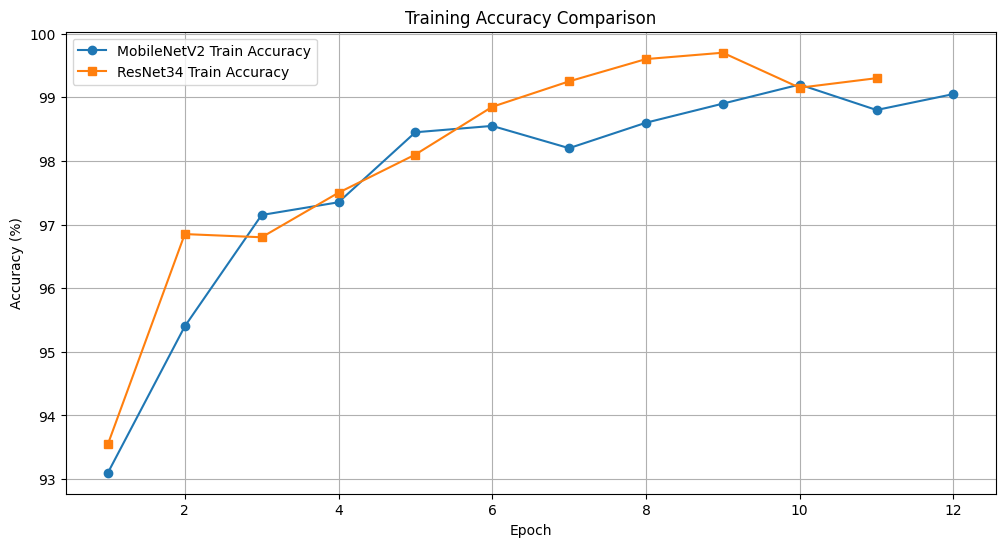

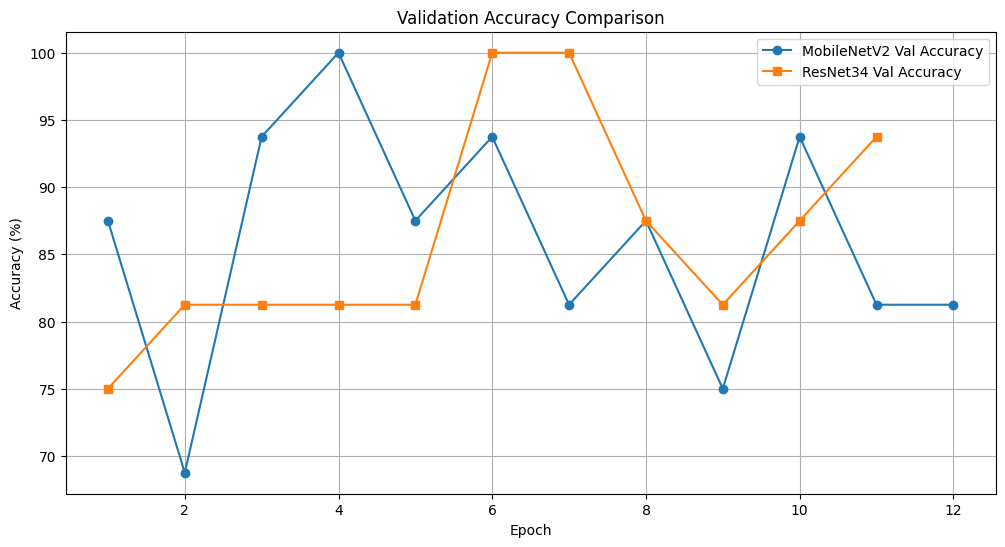

In [26]:
# Data for MobileNetV2
# Previous training session
epochs_mobilenet_previous = [1, 2, 3, 4, 5, 6]
train_loss_mobilenet_previous = [0.1824, 0.1227, 0.0869, 0.0702, 0.0476, 0.0468]
train_acc_mobilenet_previous = [93.10, 95.40, 97.15, 97.35, 98.45, 98.55]
val_loss_mobilenet_previous = [0.3713, 0.6245, 0.2537, 0.1268, 0.2689, 0.1254]
val_acc_mobilenet_previous = [87.50, 68.75, 93.75, 100.00, 87.50, 93.75]

# Current training session
epochs_mobilenet_current = [7, 8, 9, 10, 11, 12]
train_loss_mobilenet_current = [0.0492, 0.0477, 0.0382, 0.0238, 0.0328, 0.0260]
train_acc_mobilenet_current = [98.20, 98.60, 98.90, 99.20, 98.80, 99.05]
val_loss_mobilenet_current = [0.4085, 0.1789, 0.5484, 0.1894, 0.5052, 0.2442]
val_acc_mobilenet_current = [81.25, 87.50, 75.00, 93.75, 81.25, 81.25]

# Combine previous and current data
epochs_mobilenet = epochs_mobilenet_previous + epochs_mobilenet_current
train_loss_mobilenet = train_loss_mobilenet_previous + train_loss_mobilenet_current
train_acc_mobilenet = train_acc_mobilenet_previous + train_acc_mobilenet_current
val_loss_mobilenet = val_loss_mobilenet_previous + val_loss_mobilenet_current
val_acc_mobilenet = val_acc_mobilenet_previous + val_acc_mobilenet_current

# Data for ResNet34
# Previous training session
epochs_resnet_previous = [1, 2]
train_loss_resnet_previous = [0.1680, 0.0807]
train_acc_resnet_previous = [93.55, 96.85]
val_loss_resnet_previous = [0.5701, 0.3306]
val_acc_resnet_previous = [75.00, 81.25]

# Current training session
epochs_resnet_current = [3, 4, 5, 6, 7, 8, 9, 10, 11]
train_loss_resnet_current = [0.0867, 0.0677, 0.0561, 0.0331, 0.0225, 0.0164, 0.0111, 0.0179, 0.0172]
train_acc_resnet_current = [96.80, 97.50, 98.10, 98.85, 99.25, 99.60, 99.70, 99.15, 99.30]
val_loss_resnet_current = [0.4463, 0.4048, 0.3673, 0.0605, 0.0400, 0.1480, 0.4109, 0.4174, 0.1149]
val_acc_resnet_current = [81.25, 81.25, 81.25, 100.00, 100.00, 87.50, 81.25, 87.50, 93.75]

# Combine previous and current data
epochs_resnet = epochs_resnet_previous + epochs_resnet_current
train_loss_resnet = train_loss_resnet_previous + train_loss_resnet_current
train_acc_resnet = train_acc_resnet_previous + train_acc_resnet_current
val_loss_resnet = val_loss_resnet_previous + val_loss_resnet_current
val_acc_resnet = val_acc_resnet_previous + val_acc_resnet_current

# Plot Training Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_mobilenet, train_loss_mobilenet, label='MobileNetV2 Train Loss', marker='o')
plt.plot(epochs_resnet, train_loss_resnet, label='ResNet34 Train Loss', marker='s')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_mobilenet, val_loss_mobilenet, label='MobileNetV2 Val Loss', marker='o')
plt.plot(epochs_resnet, val_loss_resnet, label='ResNet34 Val Loss', marker='s')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_mobilenet, train_acc_mobilenet, label='MobileNetV2 Train Accuracy', marker='o')
plt.plot(epochs_resnet, train_acc_resnet, label='ResNet34 Train Accuracy', marker='s')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_mobilenet, val_acc_mobilenet, label='MobileNetV2 Val Accuracy', marker='o')
plt.plot(epochs_resnet, val_acc_resnet, label='ResNet34 Val Accuracy', marker='s')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


# Conclusion and Observation

**Summary of Results**

The performance of MobileNetV2 and ResNet-34 models on the validation set varied significantly. MobileNetV2 exhibited higher peaks and deeper troughs in both validation loss and accuracy, indicating periods of strong performance coupled with instability. ResNet-34, on the other hand, showed more steady and consistent progress in its learning, with fewer fluctuations but without reaching the highest accuracy observed in MobileNetV2.

**Model Comparison**

MobileNetV2 showed greater variability in both training and validation loss, with multiple spikes in validation loss across the epochs. This model's early best performance was captured at epoch 6, after which the validation loss and accuracy showed fluctuations, potentially indicating challenges with overfitting or sensitivity to hyperparameters. The final few epochs demonstrated less improvement, suggesting that further training might not have yielded substantial benefits.

ResNet-34 demonstrated stable training with smoother learning curves, showing consistent validation performance throughout. Its best performance checkpoint was at epoch 2, after which it displayed gradual improvements without significant spikes or drops. Despite its stability, ResNet-34 did not achieve the highest accuracy observed in MobileNetV2, suggesting that while it may be more reliable, it could have limitations in reaching peak performance within the given training setup.

**Key Observations**

- MobileNetV2 showed pronounced peaks and troughs in its validation metrics, indicating potential overfitting and sensitivity to learning rate or batch size adjustments. While it achieved higher accuracy during certain epochs, this came at the cost of variability and less predictable performance.
- ResNet-34 maintained more stable training behavior with steady progress and fewer fluctuations. Its learning was more controlled, leading to more predictable results, albeit with a slower improvement curve and lower peak accuracy compared to MobileNetV2.

**Strengths and Weaknesses**

**MobileNetV2:**

Strengths: Faster training cycles, higher peak accuracy achieved in some epochs.
Weaknesses: Notable fluctuations in performance metrics; less consistency; potential overfitting.


**ResNet-34:**

Strengths: Consistent training and validation metrics, suggesting a reliable model for steady learning.
Weaknesses: Slower to reach high performance, lower peak accuracy, and higher memory usage.

**Challenges and Limitations**

The training was conducted under GPU memory constraints in Google Colab, which limited the batch size and necessitated periodic checkpointing. These constraints might have influenced the variability observed, particularly in MobileNetV2. The relatively limited number of training epochs may not have fully revealed the long-term training behavior of both models. Data size and potential noise in the dataset may also have impacted model performance and generalization.

**Future Improvements**

- Experimenting with different learning rates and learning rate schedules could potentially stabilize MobileNetV2's training and reduce fluctuations.
- Employing cross-validation could provide a more robust evaluation and reduce the impact of data variability.
- Testing additional architectures, such as EfficientNet or deeper ResNet variants, may yield better results.
- Implementing further regularization techniques, like dropout or L2 regularization, could help minimize overfitting in MobileNetV2.
- Increasing the number of training epochs and optimizing data preprocessing could improve both models' performance.

**Conclusion Statement**

Both MobileNetV2 and ResNet-34 showed strong potential, with MobileNetV2 achieving higher peak accuracy but with more variability and less stability. ResNet-34, while more consistent and stable, did not reach the same peak performance level as MobileNetV2 but may be preferred for applications where predictability and reliability are more critical. Future work should focus on refining training strategies, exploring more architectures, and employing advanced regularization to enhance and balance performance outcomes.